In [1]:
# https://towardsdatascience.com/how-to-convert-json-into-a-pandas-dataframe-100b2ae1e0d8
import pandas as pd
import numpy as np
import glob, os, json
pd.set_option('display.max_columns', 35)

json_dir = os.getcwd() +'/data/'

json_pattern = os.path.join(json_dir, '*.json')
file_list = glob.glob(json_pattern)

In [2]:
dfs = []
for file in file_list:
    with open(file) as f:
        json_data = pd.json_normalize(json.loads(f.read()))
    dfs.append(json_data)

df = pd.concat(dfs)

In [3]:
df.describe()

,close-rewards,closing-amount,confirmed-round,fee,first-valid,intra-round-offset,last-valid,receiver-rewards,round-time,sender-rewards,asset-transfer-transaction.amount,asset-transfer-transaction.asset-id,asset-transfer-transaction.close-amount,signature.logicsig.multisig-signature.threshold,signature.logicsig.multisig-signature.version,signature.multisig.threshold,signature.multisig.version
count,66855.0,66855.0,6.685500e+04,66855.000000,6.685500e+04,66855.000000,6.685500e+04,66855.0,6.685500e+04,6.685500e+04,6.685500e+04,66855.0,66855.0,8922.0,8922.0,72.000000,72.0
mean,0.0,0.0,1.448745e+07,1128.017186,1.448745e+07,25.285020,1.448845e+07,0.0,1.623993e+09,3.112819e+06,1.119281e+11,31566704.0,0.0,2.0,1.0,2.527778,1.0
std,0.0,0.0,1.721471e+06,5559.441123,1.721471e+06,32.240918,1.721471e+06,0.0,7.567248e+06,2.645707e+08,9.036957e+11,0.0,0.0,0.0,0.0,0.502731,0.0
min,0.0,0.0,1.161112e+07,1000.000000,1.161112e+07,0.000000,1.161212e+07,0.0,1.611337e+09,0.000000e+00,2.000000e+00,31566704.0,0.0,2.0,1.0,2.000000,1.0
25%,0.0,0.0,1.296338e+07,1000.000000,1.296338e+07,10.000000,1.296438e+07,0.0,1.617285e+09,0.000000e+00,1.648000e+07,31566704.0,0.0,2.0,1.0,2.000000,1.0
50%,0.0,0.0,1.448360e+07,1000.000000,1.448360e+07,20.000000,1.448460e+07,0.0,1.623989e+09,0.000000e+00,3.716100e+08,31566704.0,0.0,2.0,1.0,3.000000,1.0
75%,0.0,0.0,1.624680e+07,1000.000000,1.624680e+07,34.000000,1.624780e+07,0.0,1.631729e+09,3.036000e+03,7.249085e+09,31566704.0,0.0,2.0,1.0,3.000000,1.0
max,0.0,0.0,1.671100e+07,261000.000000,1.671099e+07,2353.000000,1.671199e+07,0.0,1.633758e+09,3.691126e+10,9.700000e+13,31566704.0,0.0,2.0,1.0,3.000000,1.0


In [4]:
df.head(5)

,close-rewards,closing-amount,confirmed-round,fee,first-valid,genesis-hash,id,intra-round-offset,last-valid,lease,receiver-rewards,round-time,sender,sender-rewards,tx-type,asset-transfer-transaction.amount,asset-transfer-transaction.asset-id,asset-transfer-transaction.close-amount,asset-transfer-transaction.receiver,signature.sig,signature.logicsig.args,signature.logicsig.logic,signature.logicsig.multisig-signature.subsignature,signature.logicsig.multisig-signature.threshold,signature.logicsig.multisig-signature.version,genesis-id,group,note,signature.multisig.subsignature,signature.multisig.threshold,signature.multisig.version,asset-transfer-transaction.close-to
0,0,0,14651056,1000,14651052,wGHE2Pwdvd7S12BL5FaOP20EGYesN73ktiC1qzkkit8=,77V5EVCRQ4AYXZTB6EXNVHYCY3F7ZD5MZ4AV6S3MCD5E5F...,27,14652052,6D8z9AsoLigs2gwedoUijR3ftp5J7TS3/K9Oh69K3Ds=,0,1624721750,ZG54ZBZ5LVWV3MTGOPDSKCBL5LEQTAPUTN5OQQZUMTAYV3...,997,axfer,9208990000,31566704,0,2UEQTE5QDNXPI7M3TU44G6SYKLFWLPQO7EBZM7K7MHMQQM...,XC79J+JKOQkCKnOPOHG0eYGUbOMNvVkMy2j7pceiklI5fV...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,14651197,1000,14651194,wGHE2Pwdvd7S12BL5FaOP20EGYesN73ktiC1qzkkit8=,IRBAPPLBLYPFFMJXLJ7Y4LTUNKZUBROKQYTPSVEFDHDMT6...,47,14652194,ObB+0T90MuHTDASCHI2R7Y3iaGLIxYhvl/yJWIkBuDQ=,0,1624722362,ZG54ZBZ5LVWV3MTGOPDSKCBL5LEQTAPUTN5OQQZUMTAYV3...,997,axfer,585490000,31566704,0,2UEQTE5QDNXPI7M3TU44G6SYKLFWLPQO7EBZM7K7MHMQQM...,7ImQqgdtMyllqdCh2kchf23dZ4Up+7Tvu6ZlWM0cODBv2Z...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,14651403,1000,14651399,wGHE2Pwdvd7S12BL5FaOP20EGYesN73ktiC1qzkkit8=,7NNQN77V2NHXOWBDG573BU23JKBUNCXKC7J5O5EUHHUTIK...,0,14652399,9oWmeC4/Owoi7Xmu90+0cM616h2OIOT38O6hcgAE7vE=,0,1624723258,ZG54ZBZ5LVWV3MTGOPDSKCBL5LEQTAPUTN5OQQZUMTAYV3...,1994,axfer,112000000,31566704,0,2UEQTE5QDNXPI7M3TU44G6SYKLFWLPQO7EBZM7K7MHMQQM...,Pia6tL6RxAmFDAQ0msfmgtFAwrkoDKqi/ImRO9vb0sXXGv...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,14651681,1000,14651678,wGHE2Pwdvd7S12BL5FaOP20EGYesN73ktiC1qzkkit8=,47C3O7ADWDJAMRUARMOG5UNXP2IWDCZFUSMG2H6RKRGJR5...,83,14652678,3cuzbppzzBsfo4RQzMKlCFbdyPWVq65XKkEG2q+lCUw=,0,1624724466,ZG54ZBZ5LVWV3MTGOPDSKCBL5LEQTAPUTN5OQQZUMTAYV3...,1994,axfer,280500410000,31566704,0,2UEQTE5QDNXPI7M3TU44G6SYKLFWLPQO7EBZM7K7MHMQQM...,5FbxOp9jMKgXO3617f1oEr9D0GrFSNAwYVbNaS9pqgXuD1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,14651820,1000,14651816,wGHE2Pwdvd7S12BL5FaOP20EGYesN73ktiC1qzkkit8=,N2KVFOAA5ZSXPJN3M2ZYT5TNIUERNYLQMQH6XRYBAEPKOW...,1,14652816,Xug5KWS+7kxlpEmOOsPvEiYybj5rq6OPcoDdTuPKuM4=,0,1624725074,2UEQTE5QDNXPI7M3TU44G6SYKLFWLPQO7EBZM7K7MHMQQM...,56870,axfer,103121650000,31566704,0,ZG54ZBZ5LVWV3MTGOPDSKCBL5LEQTAPUTN5OQQZUMTAYV3...,NaN,[7i1nzZPvkk/3Tpoi9uuslxjUKg/dPpWLzFpwIwy0FL0vZ...,ASADwMyNCATw1oYPJgIgybvMhz1dbV2yZnPHJQgr6skJgf...,[{'public-key': 'v8w/YDBK3MmuXQg3njxy1K9cgEZIN...,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.describe()

,close-rewards,closing-amount,confirmed-round,fee,first-valid,intra-round-offset,last-valid,receiver-rewards,sender-rewards,asset-transfer-transaction.amount,asset-transfer-transaction.asset-id,asset-transfer-transaction.close-amount,signature.logicsig.multisig-signature.threshold,signature.logicsig.multisig-signature.version,signature.multisig.threshold,signature.multisig.version
count,66855.0,66855.0,6.685500e+04,66855.000000,6.685500e+04,66855.000000,6.685500e+04,66855.0,6.685500e+04,6.685500e+04,66855.0,66855.0,8922.0,8922.0,72.000000,72.0
mean,0.0,0.0,1.448745e+07,1128.017186,1.448745e+07,25.285020,1.448845e+07,0.0,3.112819e+06,1.119281e+11,31566704.0,0.0,2.0,1.0,2.527778,1.0
std,0.0,0.0,1.721471e+06,5559.441123,1.721471e+06,32.240918,1.721471e+06,0.0,2.645707e+08,9.036957e+11,0.0,0.0,0.0,0.0,0.502731,0.0
min,0.0,0.0,1.161112e+07,1000.000000,1.161112e+07,0.000000,1.161212e+07,0.0,0.000000e+00,2.000000e+00,31566704.0,0.0,2.0,1.0,2.000000,1.0
25%,0.0,0.0,1.296338e+07,1000.000000,1.296338e+07,10.000000,1.296438e+07,0.0,0.000000e+00,1.648000e+07,31566704.0,0.0,2.0,1.0,2.000000,1.0
50%,0.0,0.0,1.448360e+07,1000.000000,1.448360e+07,20.000000,1.448460e+07,0.0,0.000000e+00,3.716100e+08,31566704.0,0.0,2.0,1.0,3.000000,1.0
75%,0.0,0.0,1.624680e+07,1000.000000,1.624680e+07,34.000000,1.624780e+07,0.0,3.036000e+03,7.249085e+09,31566704.0,0.0,2.0,1.0,3.000000,1.0
max,0.0,0.0,1.671100e+07,261000.000000,1.671099e+07,2353.000000,1.671199e+07,0.0,3.691126e+10,9.700000e+13,31566704.0,0.0,2.0,1.0,3.000000,1.0


In [6]:
# Number of Unique Rounds in the data
df['confirmed-round'].nunique()

62247

In [7]:
df['round-time'] = pd.to_datetime(df['round-time'], unit='s')

In [8]:
ag_df = df.groupby(by=[df['round-time'].dt.date])['asset-transfer-transaction.amount'].agg(volume='sum', mean='mean')
ag_df

,volume,mean
round-time,,
2021-01-22,19274045960000,2.753435e+11
2021-01-23,20364109550000,4.525358e+11
2021-01-24,1661494340000,7.552247e+10
2021-01-25,13488398930000,8.536961e+10
2021-01-26,9178004730000,3.121770e+10
...,...,...
2021-10-05,69821346976647,3.473699e+11
2021-10-06,28395283336900,1.551655e+11
2021-10-07,38890149629834,1.873321e+10


## Calculate the expected Volume

In [9]:
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance, 4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [18]:
# inserting new column with yesterday's values
ag_df.loc[:,'volume-1'] = ag_df.loc[:,'volume'].shift()

# inserting another column with difference between yesterday and day before yesterday's consumption values.
ag_df.loc[:,'volume_diff'] = ag_df.loc[:,'volume'].diff()

ag_df

,volume,mean,volume-1,volume_diff
round-time,,,,
2021-01-22,19274045960000,2.753435e+11,NaN,NaN
2021-01-23,20364109550000,4.525358e+11,1.927405e+13,1.090064e+12
2021-01-24,1661494340000,7.552247e+10,2.036411e+13,-1.870262e+13
2021-01-25,13488398930000,8.536961e+10,1.661494e+12,1.182690e+13
2021-01-26,9178004730000,3.121770e+10,1.348840e+13,-4.310394e+12
...,...,...,...,...
2021-10-05,69821346976647,3.473699e+11,1.433945e+13,5.548189e+13
2021-10-06,28395283336900,1.551655e+11,6.982135e+13,-4.142606e+13
2021-10-07,38890149629834,1.873321e+10,2.839528e+13,1.049487e+13


In [19]:
# dropping NAs
ag_df = ag_df.dropna()

In [22]:
ag_df

,volume,mean,volume-1,volume_diff
round-time,,,,
2021-01-23,20364109550000,4.525358e+11,1.927405e+13,1.090064e+12
2021-01-24,1661494340000,7.552247e+10,2.036411e+13,-1.870262e+13
2021-01-25,13488398930000,8.536961e+10,1.661494e+12,1.182690e+13
2021-01-26,9178004730000,3.121770e+10,1.348840e+13,-4.310394e+12
2021-01-27,9007836700000,3.833122e+10,9.178005e+12,-1.701680e+11
...,...,...,...,...
2021-10-05,69821346976647,3.473699e+11,1.433945e+13,5.548189e+13
2021-10-06,28395283336900,1.551655e+11,6.982135e+13,-4.142606e+13
2021-10-07,38890149629834,1.873321e+10,2.839528e+13,1.049487e+13


Defining Training and Testing Data


In [43]:
train = ag_df[:int(len(ag_df)*0.8)]
test = ag_df[int(len(ag_df)*0.8):]

X_train, X_test, y_train, y_test = train.drop('volume', axis=1), test.drop('volume', axis=1), train['volume'], test['volume']

Cross Validation

LR: -0.000295 (0.000203)
KNN: -134903749372518785938882560.000000 (74949917937382404478992384.000000)


/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status

NN: -480011670344051589120.000000 (241302393136723066880.000000)
GB: -93271645774125425536008192.000000 (45383072231212252424830976.000000)
RF: -118171252233839920952639488.000000 (49282838319605760812646400.000000)


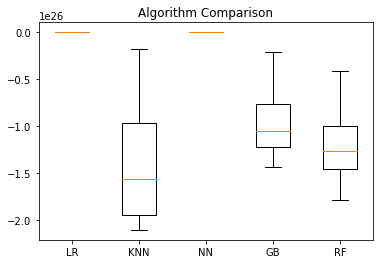

In [69]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, LassoLars, Lasso, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt  
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('NN', MLPRegressor(solver = 'lbfgs', random_state=42)))  #neural network
models.append(('GB', GradientBoostingRegressor(random_state=42))) 
models.append(('RF', RandomForestRegressor(n_estimators = 10, random_state=42))) # Ensemble method - collection of many decision trees


# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=4)

    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()


In [70]:
from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor(random_state=42)
param_search = { 
    'n_estimators': [10, 20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [66]:
best_model

RandomForestRegressor(max_depth=13, n_estimators=50)

In [67]:
best_score

-1.187256334400984e+26

In [71]:
model = MLPRegressor(random_state=1)
param_search = { 
    'max_iter': [10, 20, 50, 100, 200, 400],
    'solver': ['lbfgs', 'sgd', 'adam'],
}
tscv = TimeSeriesSplit(n_splits=4)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status

/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocess

/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.p

/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preproces

/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron

/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/fedorovn19/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [-6.52145964e+22             nan -1.34047075e+27 -2.08316648e+22
             nan -1.02034168e+27 -3.21332387e+21            

In [72]:
best_model

MLPRegressor(max_iter=400, random_state=1, solver='lbfgs')

In [73]:
best_score

-2.2256854629536704e+20